# Setup and Imports

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot style
plt.style.use("ggplot")
sns.set(font_scale=1.1)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
# For consistent randomness if needed
np.random.seed(42)

# Load Datasets

In [35]:
# Load internal data
internal_df_flows = pd.read_csv("../data/daily_flow_table.csv", parse_dates=["date"])

# Load perturbed Morningstar data
morningstar_df_flows = pd.read_csv("../data/morningstar_flow_table_perturbed.csv", parse_dates=["date"])

# Load perturbed Bloomberg data
bloomberg_df_flows = pd.read_csv("../data/bloomberg_flow_table_perturbed.csv", parse_dates=["date"])

# Preview
internal_df_flows.head(2), morningstar_df_flows.head(2), bloomberg_df_flows.head(2)

(  ticker_id    asset_name asset_type   provider       date        inflow       outflow      net_flow     nav
 0       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-01  2.790884e+08  2.282514e+08  5.083700e+07  162.21
 1       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-02  2.214562e+07  3.302482e+08 -3.081026e+08  162.10,
   ticker_id    asset_name asset_type   provider       date        inflow       outflow      net_flow     nav
 0       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-01  2.862376e+08  2.287465e+08  5.749107e+07  162.21
 1       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-02  2.363823e+07  3.315475e+08 -3.079093e+08  162.10,
   ticker_id    asset_name asset_type   provider       date        inflow       outflow      net_flow     nav
 0       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-01  2.812535e+08  2.309926e+08  5.026093e+07  162.21
 1       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-02  2.501097e+07  3.326184e+08 -3.076074e+08  162.10)

# Clean and Rename Columns

In [36]:
# Columns to keep
cols = ["ticker_id", "provider", "date", "inflow", "outflow", "net_flow"]

# Clean & rename internal
internal_df_flows = internal_df_flows[cols].rename(columns={
    "inflow": "inflow_internal",
    "outflow": "outflow_internal",
    "net_flow": "net_flow_internal"
})

# Clean & rename Morningstar
morningstar_df_flows = morningstar_df_flows[cols].rename(columns={
    "inflow": "inflow_mstar",
    "outflow": "outflow_mstar",
    "net_flow": "net_flow_mstar"
})

# Clean & rename Bloomberg
bloomberg_df_flows = bloomberg_df_flows[cols].rename(columns={
    "inflow": "inflow_bbg",
    "outflow": "outflow_bbg",
    "net_flow": "net_flow_bbg"
})

# Preview internal
internal_df_flows.head()

,ticker_id,provider,date,inflow_internal,outflow_internal,net_flow_internal
0,SPY,BlackRock,2024-01-01,2.790884e+08,2.282514e+08,5.083700e+07
1,SPY,BlackRock,2024-01-02,2.214562e+07,3.302482e+08,-3.081026e+08
2,SPY,BlackRock,2024-01-03,2.291880e+08,2.699678e+08,-4.077986e+07
3,SPY,BlackRock,2024-01-04,6.932467e+07,6.992690e+07,-6.022345e+05
4,SPY,BlackRock,2024-01-05,1.159989e+08,2.000746e+08,-8.407576e+07


# Merge All Three Datasets

In [37]:
# Merge internal and Morningstar first
merged_df = pd.merge(
    internal_df_flows,
    morningstar_df_flows,
    on=["ticker_id", "provider", "date"],
    how="inner"
)

# Merge in Bloomberg data
merged_df = pd.merge(
    merged_df,
    bloomberg_df_flows,
    on=["ticker_id", "provider", "date"],
    how="inner"
)

# Preview merged data
merged_df.head()

,ticker_id,provider,date,inflow_internal,outflow_internal,net_flow_internal,inflow_mstar,outflow_mstar,net_flow_mstar,inflow_bbg,outflow_bbg,net_flow_bbg
0,SPY,BlackRock,2024-01-01,2.790884e+08,2.282514e+08,5.083700e+07,2.862376e+08,2.287465e+08,5.749107e+07,2.812535e+08,2.309926e+08,5.026093e+07
1,SPY,BlackRock,2024-01-02,2.214562e+07,3.302482e+08,-3.081026e+08,2.363823e+07,3.315475e+08,-3.079093e+08,2.501097e+07,3.326184e+08,-3.076074e+08
2,SPY,BlackRock,2024-01-03,2.291880e+08,2.699678e+08,-4.077986e+07,2.307983e+08,2.714666e+08,-4.066825e+07,2.297194e+08,2.701330e+08,-4.041357e+07
3,SPY,BlackRock,2024-01-04,6.932467e+07,6.992690e+07,-6.022345e+05,7.026934e+07,7.106912e+07,-7.997796e+05,7.082328e+07,7.113441e+07,-3.111331e+05
4,SPY,BlackRock,2024-01-05,1.159989e+08,2.000746e+08,-8.407576e+07,1.236285e+08,2.017071e+08,-7.807866e+07,1.172184e+08,2.056761e+08,-8.845772e+07


# Compute Discrepancies

In [38]:
for source in ["mstar", "bbg"]:
    for metric in ["inflow", "outflow", "net_flow"]:
        col_internal = f"{metric}_internal"
        col_source = f"{metric}_{source}"
        
        # Absolute difference
        merged_df[f"{metric}_abs_diff_{source}"] = (merged_df[col_internal] - merged_df[col_source]).abs().round(2)
        
        # Relative difference (avoid divide-by-zero)
        merged_df[f"{metric}_rel_diff_{source}"] = np.where(
            merged_df[col_internal] != 0,
            (merged_df[col_internal] - merged_df[col_source]).abs() / merged_df[col_internal],
            np.nan
        ).round(4)

# Preview
merged_df.filter(like="diff").head()

,inflow_abs_diff_mstar,inflow_rel_diff_mstar,outflow_abs_diff_mstar,outflow_rel_diff_mstar,net_flow_abs_diff_mstar,net_flow_rel_diff_mstar,inflow_abs_diff_bbg,inflow_rel_diff_bbg,outflow_abs_diff_bbg,outflow_rel_diff_bbg,net_flow_abs_diff_bbg,net_flow_rel_diff_bbg
0,7149213.04,0.0256,495145.07,0.0022,6654067.97,0.1309,2165120.80,0.0078,2741188.04,0.0120,576067.24,0.0113
1,1492609.43,0.0674,1299285.14,0.0039,193324.29,-0.0006,2865347.26,0.1294,2370147.20,0.0072,495200.06,-0.0016
2,1610341.92,0.0070,1498723.25,0.0056,111618.67,-0.0027,531410.90,0.0023,165115.98,0.0006,366294.92,-0.0090
3,944678.57,0.0136,1142223.68,0.0163,197545.11,-0.3280,1498612.27,0.0216,1207510.89,0.0173,291101.38,-0.4834
4,7629583.10,0.0658,1632479.93,0.0082,5997103.17,-0.0713,1219546.70,0.0105,5601504.10,0.0280,4381957.40,-0.0521


# Statistics

## Skewness and Kurtois

In [39]:
from scipy.stats import skew, kurtosis

skew_val = skew(merged_df["net_flow_rel_diff_mstar"].dropna())
kurt_val = kurtosis(merged_df["net_flow_rel_diff_mstar"].dropna(), fisher=False)

## RMSE/MAE

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(merged_df["net_flow_internal"], merged_df["net_flow_mstar"], squared=False)
mae = mean_absolute_error(merged_df["net_flow_internal"], merged_df["net_flow_mstar"])

c:\Users\Scott\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Summary

In [41]:
summary_stats = []

for source in ["mstar", "bbg"]:
    for metric in ["inflow", "outflow", "net_flow"]:
        abs_col = f"{metric}_abs_diff_{source}"
        rel_col = f"{metric}_rel_diff_{source}"
        
        summary_stats.append({
            "source": source,
            "metric": metric,
            "abs_mean": merged_df[abs_col].mean().round(2),
            "abs_median": merged_df[abs_col].median().round(2),
            "abs_std": merged_df[abs_col].std().round(2),
            "rel_mean": merged_df[rel_col].mean().round(4),
            "rel_median": merged_df[rel_col].median().round(4),
            "rel_std": merged_df[rel_col].std().round(4),
            "rel_skew": skew(merged_df[rel_col].dropna()).round(4),
            "rel_kurt": kurtosis(merged_df[rel_col].dropna(), fisher=False).round(4),
            "rmse": np.round(rmse, 2) if metric == "net_flow" else np.nan,
            "mae": np.round(mae, 2) if metric == "net_flow" else np.nan
        })

# Convert to DataFrame
discrepancy_summary = pd.DataFrame(summary_stats)

# Display
discrepancy_summary

,source,metric,abs_mean,abs_median,abs_std,rel_mean,rel_median,rel_std,rel_skew,rel_kurt,rmse,mae
0,mstar,inflow,3001149.69,2527599.10,2115903.55,0.6816,0.0352,78.7247,213.0585,47092.4346,NaN,NaN
1,mstar,outflow,2501599.56,2178145.24,1579670.19,0.3420,0.0304,11.2111,85.2107,8399.3065,NaN,NaN
2,mstar,net_flow,2011810.06,1530504.54,1794880.21,0.0066,-0.0003,6.7851,-12.8135,14118.4209,2696092.36,2011810.06
3,bbg,inflow,3509842.57,2991023.39,2374609.54,0.4844,0.0420,28.1446,152.7820,25634.0065,NaN,NaN
4,bbg,outflow,2973600.84,2615279.97,1802356.21,0.3666,0.0363,10.8196,92.5209,10690.2184,NaN,NaN
5,bbg,net_flow,2270881.63,1732894.36,2004415.39,-0.0028,-0.0003,5.1484,33.1937,5888.4402,2696092.36,2011810.06


# Visualizations

## KDE plots for relative differences

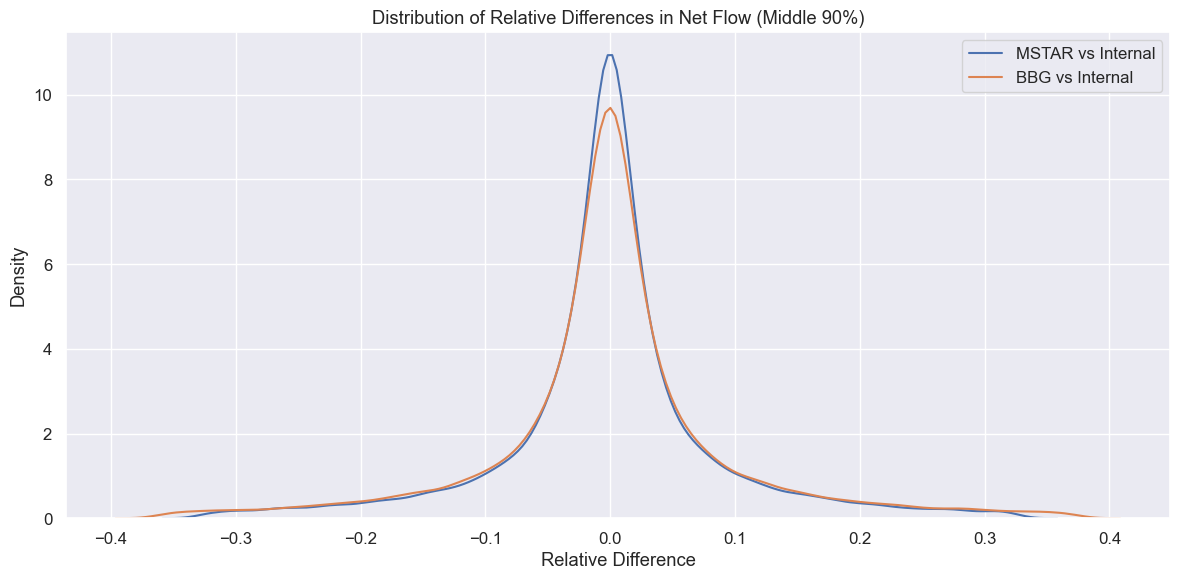

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. KDE plots for relative differences
plt.figure(figsize=(12, 6))
for source in ["mstar", "bbg"]:
    rel_diff_col = f"net_flow_rel_diff_{source}"
    filtered_data = merged_df[(merged_df[rel_diff_col] >= merged_df[rel_diff_col].quantile(0.05)) & 
                              (merged_df[rel_diff_col] <= merged_df[rel_diff_col].quantile(0.95))]
    sns.kdeplot(
        data=filtered_data,
        x=rel_diff_col,
        label=f"{source.upper()} vs Internal"
    )
plt.title("Distribution of Relative Differences in Net Flow (Middle 90%)")
plt.xlabel("Relative Difference")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

## Bar plot of mean relative differences

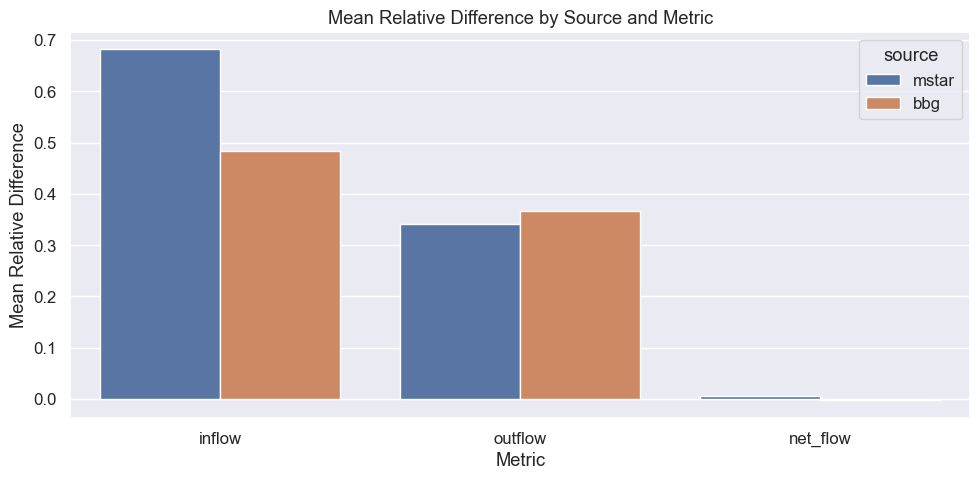

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(
    data=discrepancy_summary,
    x="metric",
    y="rel_mean",
    hue="source"
)
plt.title("Mean Relative Difference by Source and Metric")
plt.ylabel("Mean Relative Difference")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

## Box Plot of Relative Differences

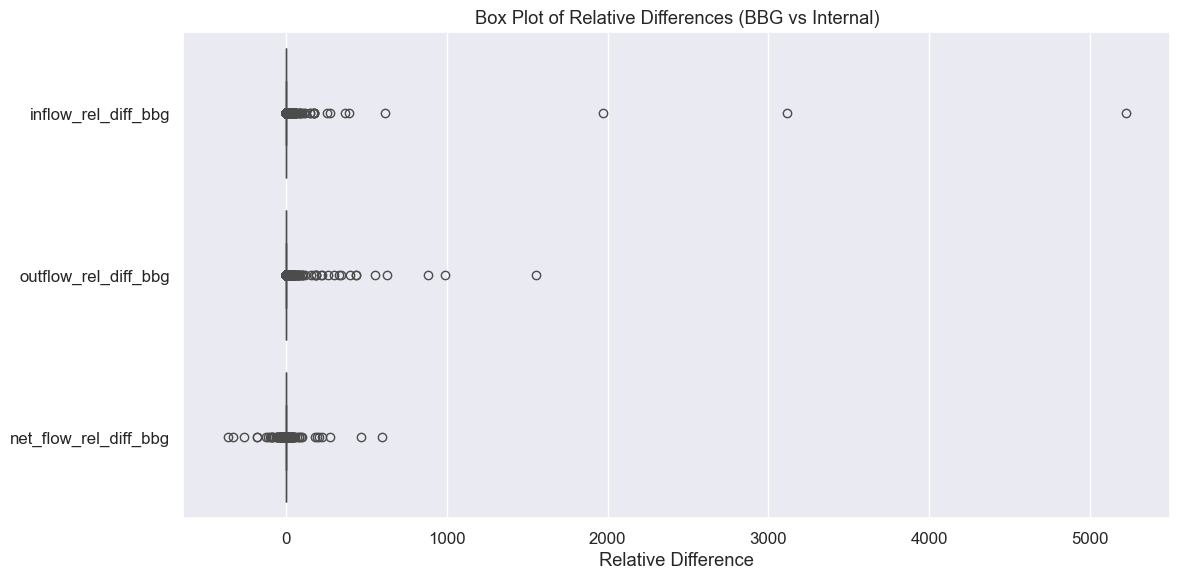

In [44]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=merged_df.filter(like="rel_diff_bbg"),
    orient="h"
)
plt.title("Box Plot of Relative Differences (BBG vs Internal)")
plt.xlabel("Relative Difference")
plt.tight_layout()
plt.show()

## QQ Plot

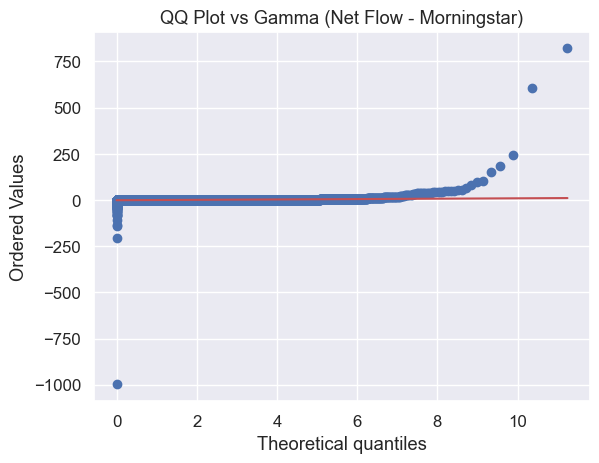

In [45]:
from scipy.stats import probplot
import matplotlib.pyplot as plt

plt.figure()
# Provide shape parameters for the gamma distribution using `sparams`
probplot(merged_df["net_flow_rel_diff_mstar"].dropna(), dist="gamma", sparams=(1,), plot=plt)
plt.title("QQ Plot vs Gamma (Net Flow - Morningstar)")
plt.show()


## ECDF of Relative Differences

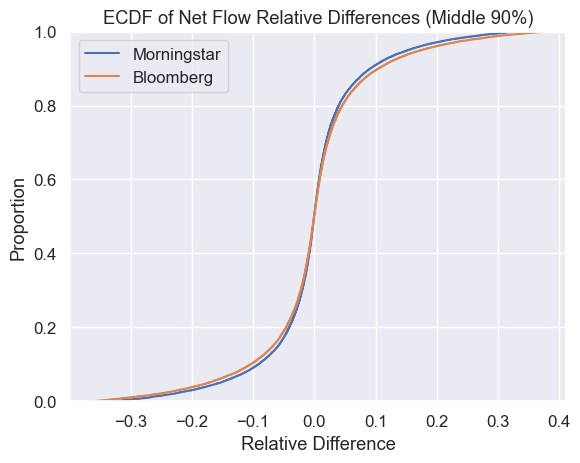

In [46]:
# Filter data to focus on the middle 90%
filtered_mstar = merged_df[(merged_df["net_flow_rel_diff_mstar"] >= merged_df["net_flow_rel_diff_mstar"].quantile(0.05)) & 
                           (merged_df["net_flow_rel_diff_mstar"] <= merged_df["net_flow_rel_diff_mstar"].quantile(0.95))]
filtered_bbg = merged_df[(merged_df["net_flow_rel_diff_bbg"] >= merged_df["net_flow_rel_diff_bbg"].quantile(0.05)) & 
                         (merged_df["net_flow_rel_diff_bbg"] <= merged_df["net_flow_rel_diff_bbg"].quantile(0.95))]

# Plot ECDF for the middle 90%
sns.ecdfplot(data=filtered_mstar, x="net_flow_rel_diff_mstar", label="Morningstar")
sns.ecdfplot(data=filtered_bbg, x="net_flow_rel_diff_bbg", label="Bloomberg")
plt.title("ECDF of Net Flow Relative Differences (Middle 90%)")
plt.xlabel("Relative Difference")
plt.legend()


## Heatmap of Mean Discrepancy by Ticker/Provider

Text(0.5, 1.0, 'Avg Net Flow Discrepancy (Morningstar) by Asset/Provider')

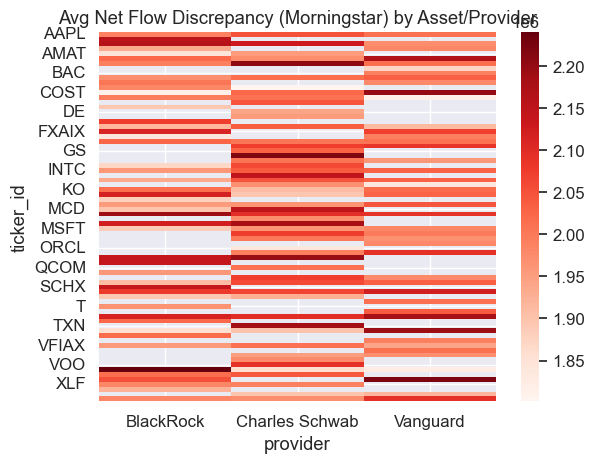

In [47]:
pivot = merged_df.groupby(["ticker_id", "provider"])["net_flow_abs_diff_mstar"].mean().unstack()
sns.heatmap(pivot, cmap="Reds", annot=False)
plt.title("Avg Net Flow Discrepancy (Morningstar) by Asset/Provider")


# Save Merged Data

In [48]:
merged_path = "../data/merged_flow_comparison.csv"
merged_df.to_csv(merged_path, index=False)

merged_path

'../data/merged_flow_comparison.csv'